# Dogs vs. Cats Classification

## Libraries

In [15]:
# Standard libraries
import numpy as np
import pickle
from glob import glob

# Image processing
import cv2

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Machine Learning
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten)

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

# Print TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


## Configuration der Hyperparameter

In [16]:
category = ["cat", "dog"]

EPOCHS = 10
IMGSIZE = 128
CHANNELS = 3 #RGB
BATCH_SIZE = 32
STOPPING_PATIENCE = 8
VERBOSE = 1
OPTIMIZER = "adam"
DATASET = "MiniDataset" # MiniDataset / HugeDataset
TRAINING_DIR = "./dataset/"+DATASET+"/training_set"
TEST_DIR = "./dataset/"+DATASET+"/test_set"

## Preprocessing Data

In [17]:
generator = ImageDataGenerator( # Reshape inside 
    rescale=1.0 / 255, # Normalize
    shear_range=0.15, # Data Augmentation ↓
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_data = generator.flow_from_directory(
    directory=TRAINING_DIR,
    target_size=(IMGSIZE, IMGSIZE),
    color_mode="rgb",
    classes=category,
    batch_size=BATCH_SIZE,
)

test_data = generator.flow_from_directory(
    directory=TEST_DIR,
    target_size=(IMGSIZE, IMGSIZE),
    color_mode="rgb",
    classes=category,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

Found 573 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


## Plot dataset

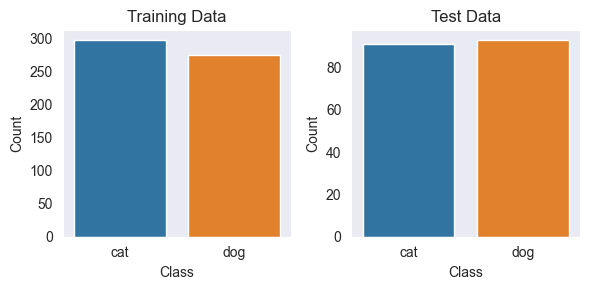

In [18]:
def plot_class_distribution(train_generator, test_generator):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3)) 

    for ax, generator, title in zip(axes, [train_generator, test_generator], ['Training Data', 'Test Data']):
        class_indices = generator.classes
        class_counts = np.bincount(class_indices)
        class_names = generator.class_indices.keys()
        label_series = np.array(list(class_names))
        class_counts_series = class_counts

        # Plot
        sns.set_style('dark')
        sns.barplot(x=label_series, y=class_counts_series, ax=ax)
        ax.set_xlabel("Class")
        ax.set_ylabel("Count")
        ax.set_title(title)

    plt.tight_layout()
    plt.show()

plot_class_distribution(train_data, test_data)

## CNN Model

In [19]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same', input_shape=(IMGSIZE, IMGSIZE, CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 = cat and dog 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

In [27]:
early_stopping = EarlyStopping(patience=STOPPING_PATIENCE, 
                   monitor='val_accuracy', 
                   mode='max', 
                   verbose=1, 
                   restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

history = model.fit(train_data, 
                    epochs=EPOCHS, 
                    validation_data=test_data,
                    shuffle=True,
                    callbacks=[early_stopping, learning_rate_reduction]
                    )

Epoch 1/10
18/18 [==============================] - 6s 323ms/step - loss: 0.9576 - accuracy: 0.5829 - val_loss: 17.4352 - val_accuracy: 0.4946 - lr: 6.2500e-05
Epoch 2/10
18/18 [==============================] - 6s 308ms/step - loss: 0.8987 - accuracy: 0.6056 - val_loss: 25.5851 - val_accuracy: 0.4946 - lr: 6.2500e-05
Epoch 3/10
18/18 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.6230
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
18/18 [==============================] - 6s 318ms/step - loss: 0.8224 - accuracy: 0.6230 - val_loss: 33.3903 - val_accuracy: 0.4946 - lr: 6.2500e-05
Epoch 4/10
18/18 [==============================] - 6s 304ms/step - loss: 0.8274 - accuracy: 0.6422 - val_loss: 40.3027 - val_accuracy: 0.4946 - lr: 3.1250e-05
Epoch 5/10
18/18 [==============================] - ETA: 0s - loss: 0.8281 - accuracy: 0.6492
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
18/18 [=======================

## Evaluation

In [21]:
test_accuracy = model.evaluate(test_data, verbose=0)

print("Test loss:", test_accuracy[0])
print("Test accuracy:", test_accuracy[1]*100 , "%")

Test loss: 7.3276824951171875
Test accuracy: 49.45652186870575 %


## Results

In [22]:
# load pretrained model 
bettertrainedmodel = load_model('dataset/catsdogs93rgb.keras')

# load history
with open('dataset/catsdogs_history93rgb.pkl', 'rb') as file_pi:
    bettertrainedmodel_history = pickle.load(file_pi)

In [23]:
test_accuracy = bettertrainedmodel.evaluate(test_data, verbose=0)

print("Test loss:", test_accuracy[0])
print("Test accuracy:", test_accuracy[1]*100 , "%")

Test loss: 0.1986086219549179
Test accuracy: 92.3913061618805 %


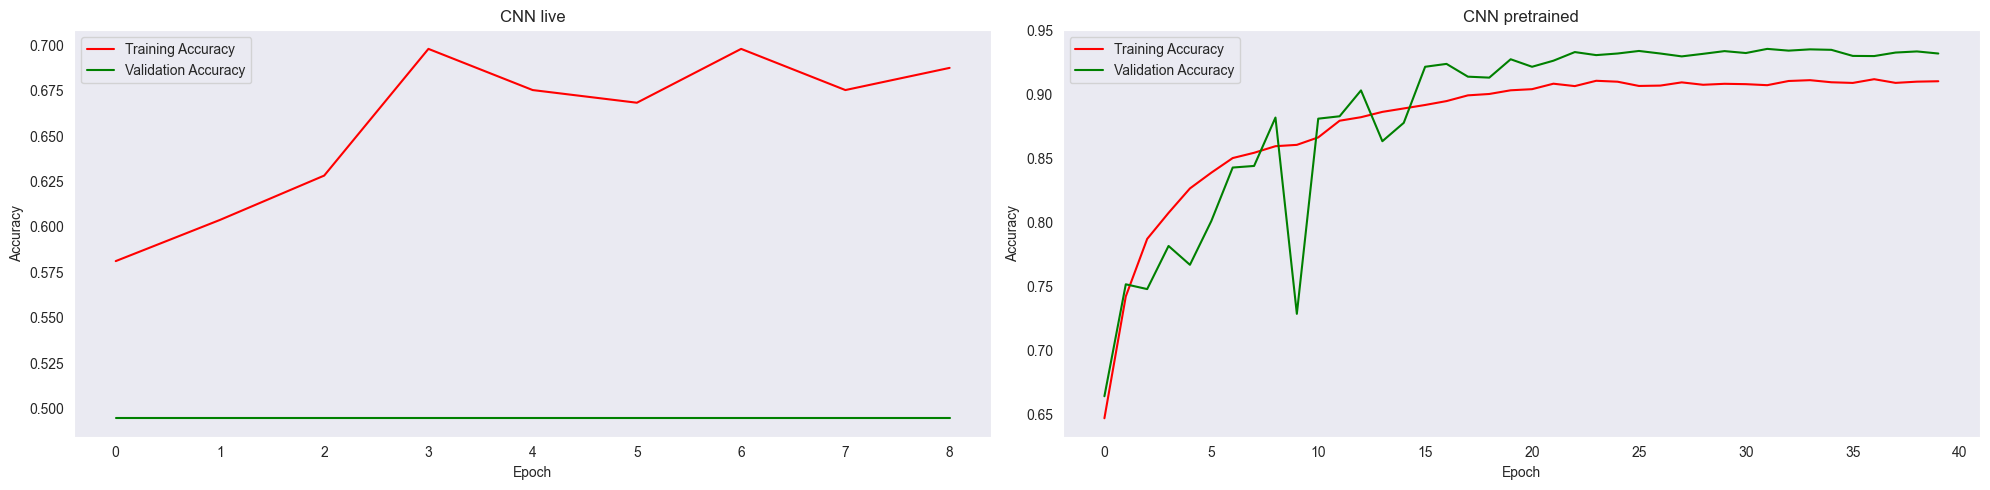

In [24]:
# Plot training & validation accuracy values
def plot_accuracy(history, title, ax):
    ax.plot(history['accuracy'], 'r-', label='Training Accuracy')
    ax.plot(history['val_accuracy'], 'g-', label='Validation Accuracy')
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_accuracy(history.history, 'CNN live', axes[0])
plot_accuracy(bettertrainedmodel_history, 'CNN pretrained', axes[1])

plt.tight_layout()
plt.show()

## Testing Visualization

In [25]:
def display_predictions(test_dir, img_size, sample_size, model, categories):
    # Load paths of images
    test_paths = np.array(glob(f"{test_dir}/*/*.jpg"))
    ids = np.random.choice(len(test_paths), size=sample_size, replace=False)
    samples = test_paths[ids]

    im_display = []  # For displaying and model prediction

    for img_path in samples:
        # Load image in color for display and prediction
        img_color = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_color = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB) 
        img_color_resized = cv2.resize(img_color, (img_size, img_size)) / 255.0
        im_display.append(img_color_resized)

    # Convert list to numpy array for model prediction
    im_test = np.array(im_display)

    # Predict using the color images
    im_pred = model.predict(im_test)

    # Plot predictions with colored images
    fig, ax = plt.subplots(3, 3, figsize=(7, 7))
    for i, axis in enumerate(ax.flat):
        if i < len(im_display):
            axis.imshow(im_display[i])
            pred_class = im_pred[i].argmax()
            pred_prob = im_pred[i].max() * 100
            axis.set_title(f'Predict: {categories[pred_class]}\nConfidence: {pred_prob:.1f}%', fontsize=12)
        else:
            axis.axis('off')

    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 69ms/step


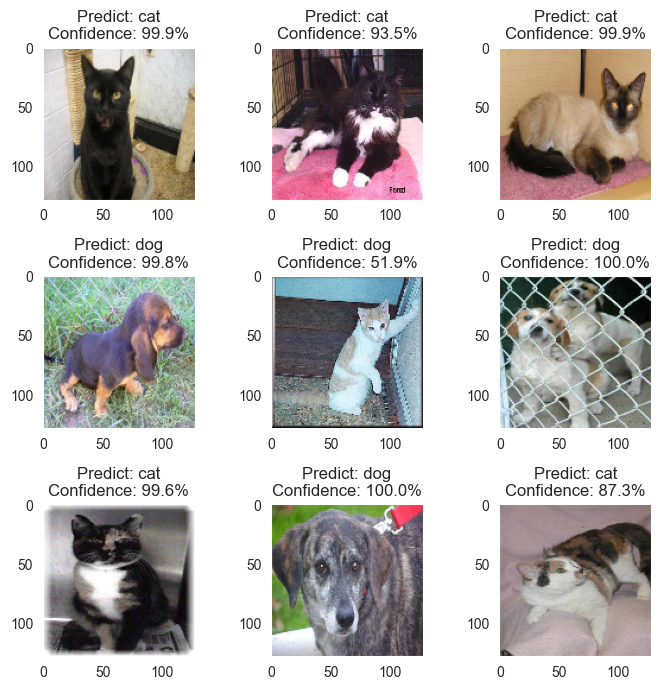

In [29]:
display_predictions(TEST_DIR, IMGSIZE, 32, bettertrainedmodel, category)